In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %pip install xgboost==1.5.0

***
### Funções

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [5]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(30, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

***
## Coleta de dados

In [6]:
FILE = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone.csv"

In [7]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [8]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
    new_clients = new_clients.sample(frac = 0.01)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [9]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
             .rename(columns={'a.peso_aparelho': 'peso_aparelho'})\
             .rename(columns={'a.update_software': 'update_software'})\
#              .drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5561999085679,724066611888352,35646010,2020-06-20,NaN,28,2,0,APPLE,IPHONE XR (A2105),...,54.99,0,1,0,2019,58.0,0.0,0.0,2105,1
1,5537988216159,724235400155647,35868409,2020-01-03,NaN,33,2,0,APPLE,IPHONE 7 (A1778),...,36.93,0,1,0,2018,73.0,0.0,0.0,1778,0
2,5514996972818,724101814995192,35308210,2022-06-13,NaN,4,0,1,APPLE,IPHONE XR (A2105),...,32.49,0,1,0,2018,33.0,2.0,2.0,2105,1
3,5519999066565,724101002089298,35220377,2022-02-24,NaN,7,0,1,APPLE,IPHONE 13 PRO (A2483),...,235.13,0,0,1,2021,26.0,12.0,19.0,2483,1
4,5511985452113,724101993008343,35270766,2022-04-11,NaN,6,0,1,APPLE,IPHONE 13 (A2633),...,0.00,0,0,1,2022,64.0,14.0,14.0,2633,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58469,5518996502888,724101702203480,35304109,2022-06-09,NaN,4,0,1,APPLE,IPHONE X (A1901),...,32.49,0,1,0,2017,19.0,30.0,30.0,1901,1
58470,5579999792973,724117307480655,35948198,2022-03-03,NaN,7,0,1,APPLE,IPHONE 13 PRO MAX (A2643),...,115.99,0,0,1,2021,57.0,47.0,47.0,2643,1
58471,5519999078973,724100901784749,35614109,2021-04-27,NaN,17,1,0,APPLE,IPHONE 6S (A1688),...,53.35,0,1,0,2018,57.0,0.0,0.0,1688,0
58472,5591992210363,724119113739463,35400984,2021-07-12,NaN,15,1,0,APPLE,IPHONE 12 PRO (A2341),...,399.99,0,0,1,2020,38.0,0.0,0.0,2341,1


### Limpeza dos dados

In [10]:
dados = dados[dados['peso_aparelho'] != 'IPHONE4']
dados = dados[dados['peso_aparelho'] != 'IPHONE3G']
dados = dados[dados['peso_aparelho'] != 'IPHONE']
dados = dados[dados['peso_aparelho'] != 'IPHONE3GS']
dados = dados[dados['peso_aparelho'] != 'DIGIPHONE K6700I']
dados = dados[dados['peso_aparelho'] != 'GENIPHONE 9 MINI']
dados = dados[dados['offertechnology'] != 'VOIP']

In [11]:
dados = dados[dados['aging_aparelho'] >= 12]

In [12]:
dados = dados[dados['aging_aparelho'] <= 48]

In [13]:
dados['aging_aparelho'].unique()

array([28, 33, 20, 14, 19, 40, 13, 26, 16, 17, 25, 18, 21, 29, 12, 22, 39,
       23, 47, 41, 32, 15, 24, 35, 34, 38, 36, 31, 37, 43, 44, 30, 45, 27,
       46, 48, 42])

In [14]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     27603
citydesc                   31549
subscribermainofferdesc       70
assignedchargeamount          67
dtype: int64

columns_with_nan.shape (4,)



In [15]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade'])\
                    .reset_index(drop=True)
# dados_droped

In [16]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      27554
citydesc    31477
dtype: int64

columns_with_nan.shape (2,)



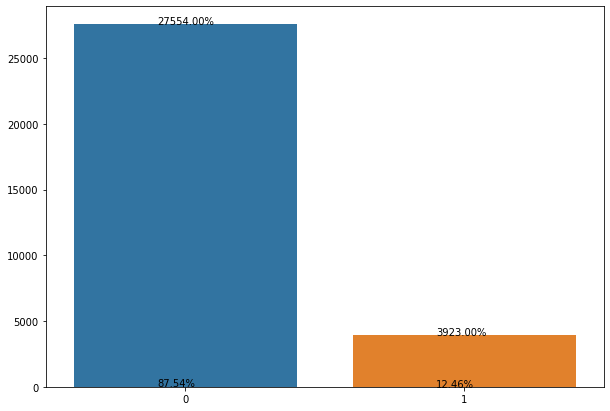

In [17]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

### Equilibrando classes

In [18]:
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
dados_droped['idade'] = np.asarray(dados_droped['idade'], dtype = 'int64')
dados_droped['fl_3g'] = np.asarray(dados_droped['fl_3g'], dtype = 'int8')
dados_droped['fl_4g'] = np.asarray(dados_droped['fl_4g'], dtype = 'int8')
dados_droped['fl_5g'] = np.asarray(dados_droped['fl_5g'], dtype = 'int8')
dados_droped['peso_aparelho'] = np.asarray(dados_droped['peso_aparelho'], dtype = 'int64')
dados_droped['update_software'] = np.asarray(dados_droped['update_software'], dtype = 'int64') 
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5561999085679,724066611888352,35646010,2020-06-20,NaN,28,2,0,APPLE,IPHONE XR (A2105),...,54.99,0,1,0,2019,58,0.0,0.0,2105,1
1,5537988216159,724235400155647,35868409,2020-01-03,NaN,33,2,0,APPLE,IPHONE 7 (A1778),...,36.93,0,1,0,2018,73,0.0,0.0,1778,0
2,5585986227929,724118593858754,35291611,2021-02-20,NaN,20,1,0,APPLE,IPHONE 11 (A2221),...,129.99,0,1,0,2020,70,0.0,0.0,2221,1
3,5519996123747,724101005117326,35167292,2021-08-03,NaN,14,1,0,APPLE,IPHONE 12 (A2403),...,99.99,0,0,1,2020,61,0.0,0.0,2403,1
4,5517992111684,724101890632553,35670508,2021-08-14,NaN,14,1,0,APPLE,IPHONE 8 (A1863),...,0.00,0,1,0,2017,40,0.0,0.0,1863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31472,5561991797797,724066005978173,35767712,2021-07-06,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2411),...,228.77,0,0,1,2020,50,0.0,0.0,2411,1
31473,5568999521987,724066635126636,35487809,2021-01-11,NaN,21,1,0,APPLE,IPHONE X (A1901),...,55.99,0,1,0,2018,44,0.0,0.0,1901,1
31474,5519999078973,724100901784749,35614109,2021-04-27,NaN,17,1,0,APPLE,IPHONE 6S (A1688),...,53.35,0,1,0,2018,57,0.0,0.0,1688,0
31475,5591992210363,724119113739463,35400984,2021-07-12,NaN,15,1,0,APPLE,IPHONE 12 PRO (A2341),...,399.99,0,0,1,2020,38,0.0,0.0,2341,1


In [19]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31477 entries, 0 to 31476
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   msisdn                   31477 non-null  int64  
 1   imsi                     31477 non-null  object 
 2   tac                      31477 non-null  int64  
 3   dt_inicio                31477 non-null  object 
 4   dt_fim                   3923 non-null   object 
 5   aging_aparelho           31477 non-null  int64  
 6   cat_aparelho             31477 non-null  int64  
 7   trocou_aparelho          31477 non-null  int64  
 8   fabricante               31477 non-null  object 
 9   modelo                   31477 non-null  object 
 10  imei                     31477 non-null  object 
 11  ranking                  31477 non-null  int64  
 12  cpfidentifier            31477 non-null  float64
 13  subscriberkey            31477 non-null  int64  
 14  customerkey           

***
## Mostrando a correlação entre os dados numéricos

In [20]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade',  'avg_msisdn', 'avg_cpf',
                                     'peso_aparelho', 'update_software', 'trocou_aparelho', 'aging_aparelho']]

<AxesSubplot:>

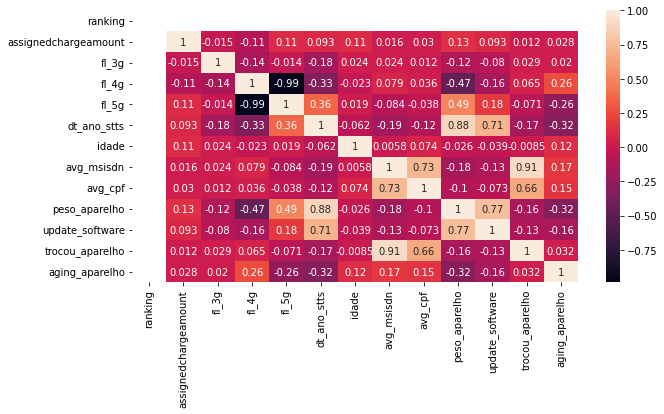

In [21]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

#### Correlação entre Meses do ano com Troca de Aparelho

In [22]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [23]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
                                 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
                                 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

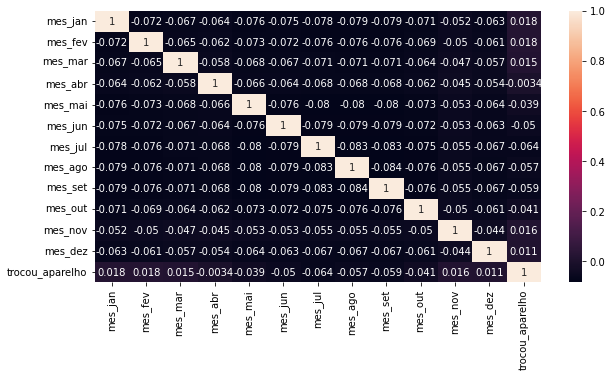

In [24]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
## Exploração dos dados

### seleção de features

In [25]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,APPLE,IPHONE XR (A2105),1,28,Controle,DISTRITO FEDERAL,VIVO CONTROLE 6GB III,54.99,0,1,0,2019,58,0.0,0.0,2105,1
1,APPLE,IPHONE 7 (A1778),1,33,Controle,MINAS GERAIS,VIVO CONTROLE 4GB,36.93,0,1,0,2018,73,0.0,0.0,1778,0
2,APPLE,IPHONE 11 (A2221),1,20,PostPaid,CEARA,TITULAR VIVO SELFIE SPOTIFY PREMIUM 30GB,129.99,0,1,0,2020,70,0.0,0.0,2221,1
3,APPLE,IPHONE 12 (A2403),1,14,PostPaid,SAO PAULO,TITULAR VIVO POS 7GB+28GB BONUS,99.99,0,0,1,2020,61,0.0,0.0,2403,1
4,APPLE,IPHONE 8 (A1863),1,14,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0,1,0,2017,40,0.0,0.0,1863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31472,APPLE,IPHONE 12 PRO MAX (A2411),1,15,PostPaid,DISTRITO FEDERAL,TITULAR VIVO FAMILIA 60GB,228.77,0,0,1,2020,50,0.0,0.0,2411,1
31473,APPLE,IPHONE X (A1901),1,21,Controle,ACRE,VIVO CONTROLE 9GB I PLN,55.99,0,1,0,2018,44,0.0,0.0,1901,1
31474,APPLE,IPHONE 6S (A1688),1,17,Controle,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0,1,0,2018,57,0.0,0.0,1688,0
31475,APPLE,IPHONE 12 PRO (A2341),1,15,PostPaid,PARA,TITULAR VIVO FAMILIA 150GB,399.99,0,0,1,2020,38,0.0,0.0,2341,1


In [26]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31477 entries, 0 to 31476
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fabricante               31477 non-null  object 
 1   modelo                   31477 non-null  object 
 2   ranking                  31477 non-null  int64  
 3   aging_aparelho           31477 non-null  int64  
 4   offertechnology          31477 non-null  object 
 5   statedesc                31477 non-null  object 
 6   subscribermainofferdesc  31477 non-null  object 
 7   assignedchargeamount     31477 non-null  float64
 8   fl_3g                    31477 non-null  int8   
 9   fl_4g                    31477 non-null  int8   
 10  fl_5g                    31477 non-null  int8   
 11  dt_ano_stts              31477 non-null  int64  
 12  idade                    31477 non-null  int64  
 13  avg_msisdn               31477 non-null  float64
 14  avg_cpf               

#### Variaveis Categoricas

In [27]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [28]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  9
['ranking', 'aging_aparelho', 'assignedchargeamount', 'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software']


***
***
***
## Definição do Target trocou_aparelho

In [29]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 27554, 1: 3923})

<Figure size 576x432 with 0 Axes>

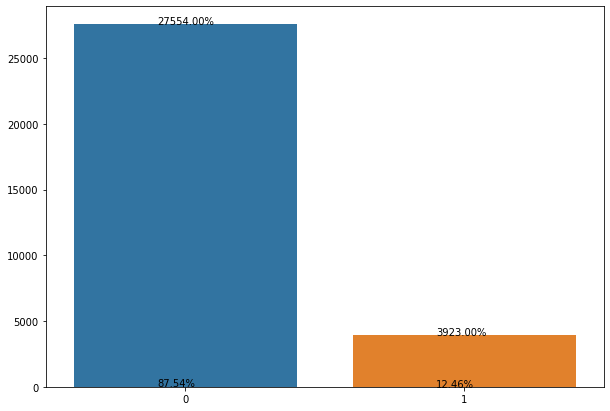

In [30]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

***
## Modelagem trocou_aparelho

In [31]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_ta[numerical_cols_ta] = scaler.fit_transform(X_ta[numerical_cols_ta])

In [32]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train_ta = X_train_ta.copy()
label_X_valid_ta = X_val_ta.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder_ta = OrdinalEncoder()
label_X_train_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_train_ta[object_cols_ta])
label_X_valid_ta[object_cols_ta] = ordinal_encoder_ta.fit_transform(label_X_valid_ta[object_cols_ta])

In [34]:
model_ta = XGBClassifier(random_state=2048, n_jobs=-1)
model_ta.fit(label_X_train_ta, y_train_ta)
preds_ta = model_ta.predict(label_X_valid_ta)

[12:38:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


***
### Feature Importance

In [35]:
import eli5
from eli5.sklearn import PermutationImportance

perm_ta = PermutationImportance(model_ta, n_iter=100).fit(label_X_valid_ta, y_val_ta)
eli5.show_weights(perm_ta, feature_names = label_X_valid_ta.columns.tolist())

Weight,Feature
0.2171 ± 0.0035,avg_msisdn
0 ± 0.0000,update_software
0 ± 0.0000,assignedchargeamount
0 ± 0.0000,modelo
0 ± 0.0000,ranking
0 ± 0.0000,aging_aparelho
0 ± 0.0000,offertechnology
0 ± 0.0000,statedesc
0 ± 0.0000,subscribermainofferdesc
0 ± 0.0000,fl_3g


Permutation explainer: 15740it [30:03,  8.70it/s]                            


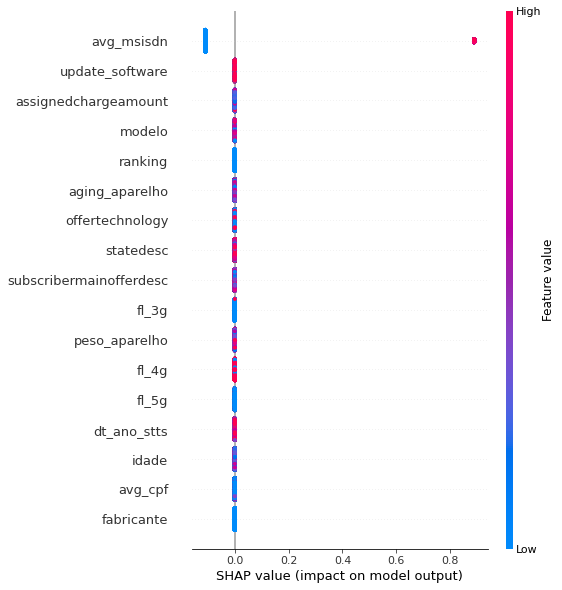

In [36]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer_ta = shap.Explainer(model_ta.predict, label_X_valid_ta)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values_ta = explainer_ta(label_X_valid_ta)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values_ta, label_X_valid_ta)

  0%|          | 0/1573 [00:00<?, ?it/s]

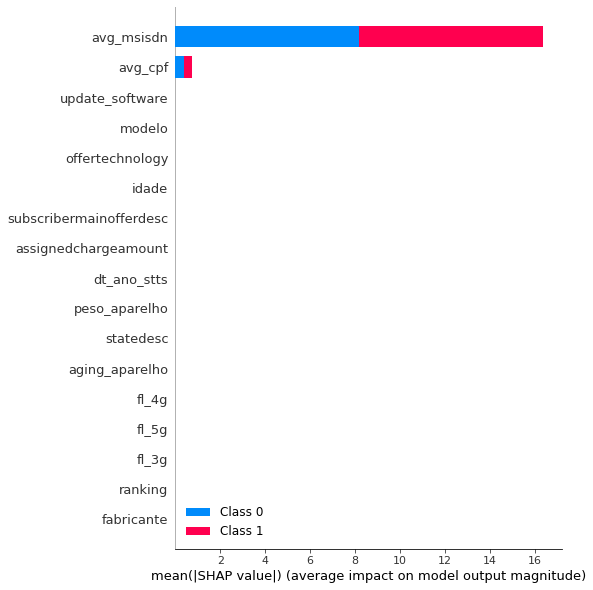

In [37]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample_ta = label_X_train_ta.sample(n=min(10, len(label_X_train_ta.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example_ta = label_X_valid_ta.sample(n=int((label_X_valid_ta.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict_ta = lambda x: model_ta.predict_proba(pd.DataFrame(x, columns=label_X_train_ta.columns))
explainer_ta2 = KernelExplainer(predict_ta, train_sample_ta, link="logit")
shap_values_ta2 = explainer_ta2.shap_values(example_ta, l1_reg=False)
summary_plot(shap_values_ta2, example_ta)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [38]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13788
           1       1.00      1.00      1.00      1951

    accuracy                           1.00     15739
   macro avg       1.00      1.00      1.00     15739
weighted avg       1.00      1.00      1.00     15739



In [39]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,13788,0
1,0,1951


Confusion matrix, without normalization
[[13788     0]
 [    0  1951]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


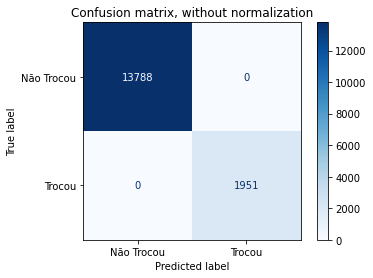

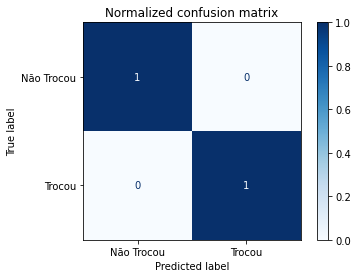

<Figure size 1296x1296 with 0 Axes>

In [40]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_ta,
        label_X_valid_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [41]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

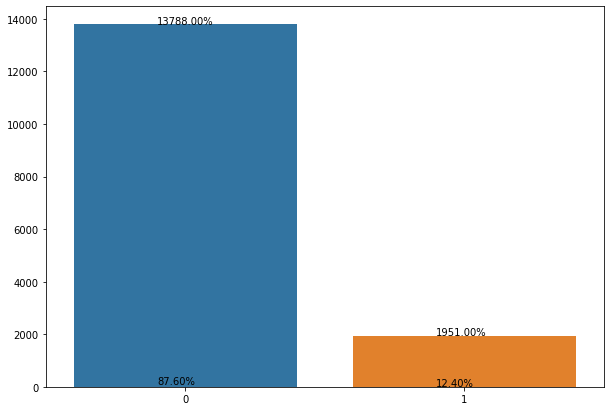

In [42]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho')

In [43]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<Figure size 576x432 with 0 Axes>

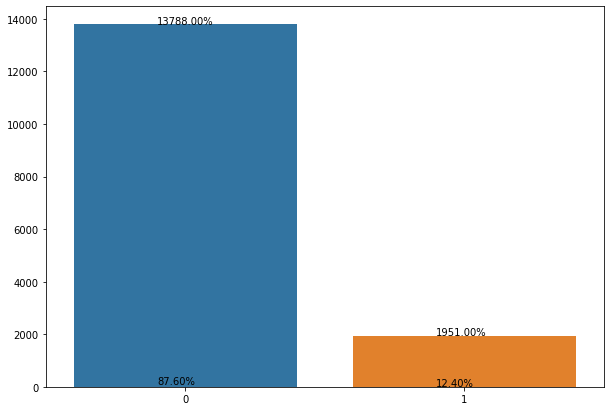

In [44]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto')

In [45]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [46]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [47]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
# X_val_ta

In [48]:
X_val_ta['aging_aparelho_ori'] = dados_droped['aging_aparelho']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
636,APPLE,IPHONE XS MAX (A2101),0.0,-1.287545,PostPaid,MINAS GERAIS,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,-0.869386,0,1,...,-0.344043,-0.079626,0.357079,0.568876,0,0,5.632637e+09,2021-10-11,NaN,12
12862,APPLE,IPHONE XR (A2105),0.0,-0.457594,PostPaid,MATO GROSSO DO SUL,TITULAR VIVO SELFIE SPOTIFY PREMIUM 30GB,0.667127,0,1,...,-0.344043,-0.452426,0.374226,0.568876,0,0,8.455894e+10,2021-01-22,NaN,20
24649,APPLE,IPHONE 7 PLUS (A1784),0.0,-0.146363,Controle,RORAIMA,VIVO CONTROLE 4GB,-0.404997,0,1,...,-0.344043,-0.452426,-1.001805,-1.757853,0,0,5.065926e+09,2020-11-07,NaN,23
1034,APPLE,IPHONE 8 PLUS (A1897),0.0,-0.976314,Controle,PERNAMBUCO,VIVO CONTROLE 7GB_,-0.188991,0,1,...,-0.344043,-0.452426,-0.517408,0.568876,0,0,1.120502e+10,2021-06-29,NaN,15
27581,APPLE,IPHONE5 (A1428),0.0,0.268613,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.309726,1,0,...,-0.344043,-0.452426,-2.527870,-1.757853,0,0,3.642553e+10,2020-07-03,NaN,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8218,APPLE,IPHONE 6S (A1688),0.0,-0.250107,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO SELFIE ESSENCIAL 20GB,0.337851,0,1,...,0.895749,0.572773,-1.413328,-1.757853,1,1,9.667451e+10,2020-06-01,2022-04-11,22
7441,APPLE,IPHONE 11 (A2221),0.0,-0.457594,PostPaid,RIO DE JANEIRO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,-0.869386,0,1,...,-0.344043,-0.452426,0.871483,0.568876,0,0,1.088037e+09,2021-02-20,NaN,20
30744,APPLE,IPHONE 6S (A1688),0.0,-0.665082,Controle,SAO PAULO,VIVOCONTROLEDIGITAL-14GB ILIM_,0.085406,0,1,...,-0.344043,-0.452426,-1.413328,-1.757853,0,0,4.373507e+09,2021-04-14,NaN,18
10626,APPLE,IPHONE 7 (A1778),0.0,-1.080058,Controle,MINAS GERAIS,VIVO CONTROLE 4GB IV,-0.457900,0,1,...,1.233874,0.852372,-1.027525,-1.757853,1,1,5.034943e+09,2021-01-04,2022-04-02,14


***
***
***
## Separando as bases para outro modelo

In [49]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,...,avg_msisdn,avg_cpf,peso_aparelho,update_software,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim,aging_aparelho_ori
0,APPLE,IPHONE 11 (A2221),0.0,-1.287545,Controle,SERGIPE,VIVO CONTROLE 4GB I PLN,-0.518268,0,1,...,1.008457,0.665973,0.871483,0.568876,1,1,6.959938e+09,2021-05-21,2022-05-28,12
1,APPLE,IPHONE 11 PRO MAX (A2161),0.0,0.476101,PostPaid,MINAS GERAIS,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,0.337851,0,1,...,2.924500,2.250370,0.614281,0.568876,1,1,6.454139e+09,2019-11-13,2022-04-23,29
2,APPLE,IPHONE 11 (A2221),0.0,0.061125,Controle,MINAS GERAIS,VIVO CTRL DIGITAL-11GB ILIM_,-0.141246,0,1,...,2.473666,1.877571,0.871483,0.568876,1,1,1.063295e+10,2020-04-24,2022-05-24,25
3,APPLE,IPHONE 11 (A2221),0.0,-1.183801,PostPaid,SAO PAULO,Linha Adicional Vivo Pós Família 300GB,-0.869386,0,1,...,1.121166,0.945572,0.871483,0.568876,1,1,2.971291e+10,2021-01-21,2022-02-23,13
4,APPLE,IPHONE 11 PRO (A2160),0.0,0.268613,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,-0.869386,0,1,...,2.699083,1.908327,0.609994,0.568876,1,1,7.211468e+10,2020-01-16,2022-04-21,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,APPLE,IPHONE 11 PRO MAX (A2218),0.0,-0.250107,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.364605,0,1,...,2.135541,1.597971,0.858623,0.568876,1,1,2.904717e+10,2020-08-15,2022-06-18,22
1947,APPLE,IPHONE 6S (A1688),0.0,-0.768826,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,-0.243871,0,1,...,1.571999,1.131972,-1.413328,-1.757853,1,1,4.961718e+10,2020-12-11,2022-05-25,17
1948,APPLE,IPHONE 8 PLUS (A1897),0.0,0.268613,PostPaid,TOCANTINS,LINHA ADICIONAL VIVO FAMILIA 60GB,-0.869386,0,1,...,2.699083,2.063971,-0.517408,0.568876,1,1,4.808765e+10,2020-02-20,2022-06-09,27
1949,APPLE,IPHONE 6S (A1688),0.0,-0.250107,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO SELFIE ESSENCIAL 20GB,0.337851,0,1,...,0.895749,0.572773,-1.413328,-1.757853,1,1,9.667451e+10,2020-06-01,2022-04-11,22


***
***
***
## Definição do Target aging_aparelho

In [50]:
# define target
y = base_to_pred_month['aging_aparelho_ori']

In [51]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({12: 95,
         29: 67,
         25: 62,
         13: 105,
         27: 70,
         28: 76,
         18: 73,
         15: 103,
         17: 74,
         24: 60,
         32: 41,
         23: 56,
         19: 61,
         14: 104,
         33: 36,
         35: 54,
         38: 39,
         43: 26,
         40: 38,
         37: 36,
         46: 20,
         21: 59,
         48: 16,
         22: 55,
         34: 36,
         39: 22,
         31: 51,
         16: 73,
         41: 29,
         36: 49,
         44: 12,
         26: 69,
         30: 65,
         20: 66,
         42: 18,
         47: 19,
         45: 16})

<Figure size 1440x432 with 0 Axes>

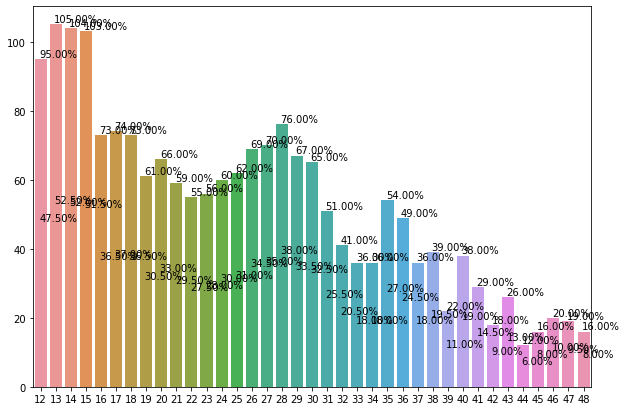

In [52]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho_ori')

### Definicão das features

In [53]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 
                        'peso_aparelho', 'update_software']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,APPLE,IPHONE 11 (A2221),0.0,Controle,SERGIPE,VIVO CONTROLE 4GB I PLN,-0.518268,0,1,0,1.053759,-1.150038,1.008457,0.665973,0.871483,0.568876
1,APPLE,IPHONE 11 PRO MAX (A2161),0.0,PostPaid,MINAS GERAIS,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,0.337851,0,1,0,0.445976,-0.403432,2.924500,2.250370,0.614281,0.568876
2,APPLE,IPHONE 11 (A2221),0.0,Controle,MINAS GERAIS,VIVO CTRL DIGITAL-11GB ILIM_,-0.141246,0,1,0,0.445976,-1.082165,2.473666,1.877571,0.871483,0.568876
3,APPLE,IPHONE 11 (A2221),0.0,PostPaid,SAO PAULO,Linha Adicional Vivo Pós Família 300GB,-0.869386,0,1,0,1.053759,-0.199812,1.121166,0.945572,0.871483,0.568876
4,APPLE,IPHONE 11 PRO (A2160),0.0,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,-0.869386,0,1,0,0.445976,0.411048,2.699083,1.908327,0.609994,0.568876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,APPLE,IPHONE 11 PRO MAX (A2218),0.0,Controle,SAO PAULO,VIVO CONTROLE 6GB III,-0.364605,0,1,0,0.445976,-0.199812,2.135541,1.597971,0.858623,0.568876
1947,APPLE,IPHONE 6S (A1688),0.0,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_,-0.243871,0,1,0,-0.161808,0.750414,1.571999,1.131972,-1.413328,-1.757853
1948,APPLE,IPHONE 8 PLUS (A1897),0.0,PostPaid,TOCANTINS,LINHA ADICIONAL VIVO FAMILIA 60GB,-0.869386,0,1,0,-0.161808,1.021908,2.699083,2.063971,-0.517408,0.568876
1949,APPLE,IPHONE 6S (A1688),0.0,PostPaid,RIO GRANDE DO SUL,TITULAR VIVO SELFIE ESSENCIAL 20GB,0.337851,0,1,0,-0.161808,0.614668,0.895749,0.572773,-1.413328,-1.757853


#### Variaveis Categoricas

In [54]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [55]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  8
['ranking', 'assignedchargeamount', 'dt_ano_stts', 'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software']


***
## Mostrando a correlação entre os dados numéricos

In [56]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho_ori', 'avg_msisdn', 'avg_cpf', 
                                        'peso_aparelho', 'update_software']]

<AxesSubplot:>

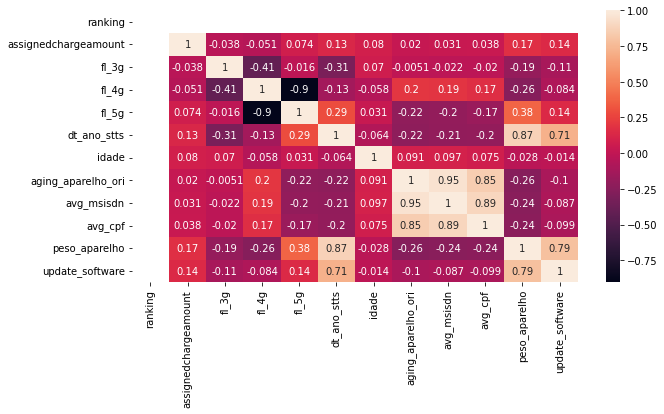

In [57]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [58]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [59]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

In [60]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

model = XGBClassifier(random_state=2048, n_jobs=-1)
model.fit(label_X_train, y_train)
preds = model.predict(label_X_valid)

[13:15:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


***
### Feature Importance

In [61]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=100).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())


Weight,Feature
0.9036 ± 0.0134,avg_msisdn
0.0110 ± 0.0036,avg_cpf
0.0030 ± 0.0040,assignedchargeamount
0.0020 ± 0.0024,dt_ano_stts
0.0017 ± 0.0028,subscribermainofferdesc
0.0014 ± 0.0025,statedesc
0.0005 ± 0.0031,idade
0.0004 ± 0.0021,modelo
0.0001 ± 0.0028,peso_aparelho
0 ± 0.0000,update_software


Permutation explainer: 977it [08:55,  1.79it/s]                         


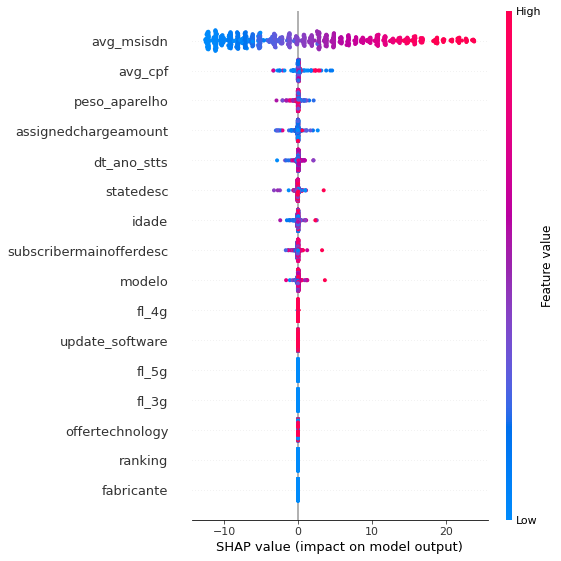

In [62]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)

  0%|          | 0/97 [00:00<?, ?it/s]

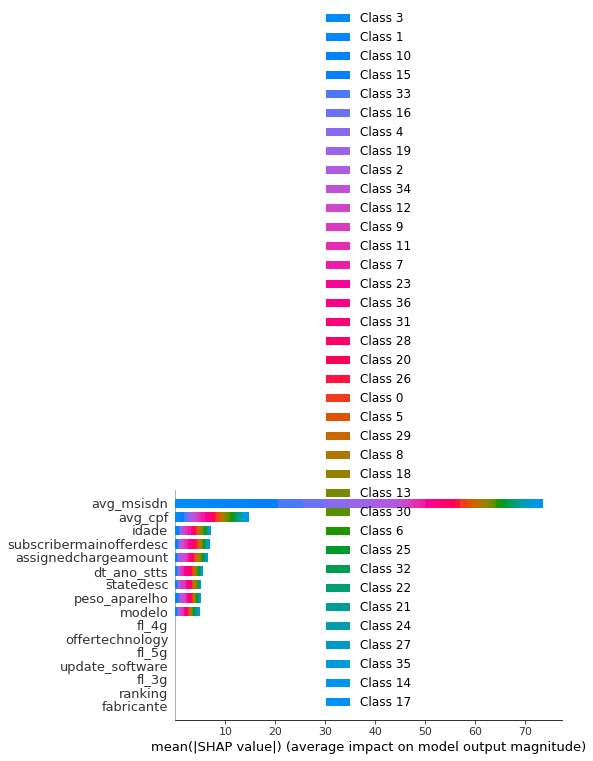

In [63]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = label_X_train.sample(n=min(10, len(label_X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = label_X_valid.sample(n=int((label_X_valid.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=label_X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

***
## Métricas

In [64]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.87      0.94      0.90        49
          13       0.89      0.98      0.93        55
          14       0.92      0.92      0.92        37
          15       0.92      0.92      0.92        59
          16       0.76      0.91      0.83        35
          17       0.89      0.94      0.91        34
          18       0.87      1.00      0.93        39
          19       1.00      0.91      0.95        34
          20       0.97      0.94      0.96        35
          21       1.00      0.87      0.93        31
          22       0.96      0.86      0.91        28
          23       0.97      0.88      0.92        33
          24       1.00      0.96      0.98        25
          25       1.00      0.97      0.98        30
          26       1.00      0.97      0.99        36
          27       1.00      0.95      0.97        41
          28       0.88      1.00      0.94        30
          29       1.00    

In [65]:
# cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
#                      index = sorted(Counter(y_val)),
#                      columns = sorted(Counter(preds)))
# cm_df

## Plot non-normalized confusion matrix

In [66]:
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
#         model,
#         label_X_valid,
#         y_val,
#         display_labels=y.unique(),
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)
    
# plt.figure(figsize=(18, 18))
# plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [67]:
X_val['aging_aparelho'] = y_val
# X_val

In [68]:
X_val['previsto'] = preds
# X_val

In [69]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [70]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [71]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [72]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,...,avg_msisdn,avg_cpf,peso_aparelho,update_software,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
743,APPLE,IPHONE 7 PLUS (A1784),0.0,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 150GB,-0.828184,0,1,0,...,0.446057,0.546026,-0.615010,-1.289056,29,29,1.091578e+10,2019-09-15,2022-02-20,2022-02
1450,APPLE,IPHONE 8 (A1905),0.0,Controle,SAO PAULO,VIVO CONTROLE 5GB II,-0.410239,0,1,0,...,0.046082,0.142403,-0.074980,0.775762,25,25,2.877007e+10,2020-02-08,2022-03-19,2022-03
1144,APPLE,IPHONE 11 (A2111),0.0,PostPaid,CEARA,LINHA ADICIONAL VIVO FAMILIA 100GB,-0.828184,0,1,0,...,0.246069,0.344214,0.844410,0.775762,27,27,5.120962e+10,2020-01-20,2022-05-12,2022-04
1888,APPLE,IPHONE XR (A2105),0.0,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 10GB+110GB BONUS,0.959897,0,1,0,...,0.546050,0.394667,0.817632,0.775762,30,30,2.968548e+10,2019-08-10,2022-02-17,2022-02
32,APPLE,IPHONE 11 PRO MAX (A2218),0.0,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO V,-0.828184,0,1,0,...,-1.253837,-1.446863,1.321957,0.775762,12,12,1.175422e+10,2021-01-22,2022-02-17,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,APPLE,IPHONE XR (A2105),0.0,PostPaid,MATO GROSSO DO SUL,TITULAR VIVO SELFIE NETFLIX 30GB,0.100429,0,1,0,...,0.246069,0.546026,0.817632,0.775762,27,27,8.897883e+10,2019-11-30,2022-03-07,2022-02
1545,APPLE,IPHONE 11 (A2221),0.0,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,-0.828184,0,1,0,...,-0.453887,-0.833356,1.335346,0.775762,20,20,2.176153e+10,2020-08-05,2022-04-24,2022-04
367,APPLE,IPHONE 7 PLUS (A1784),0.0,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB - MENSAL,-0.317813,0,1,0,...,-1.603815,-1.522542,-0.615010,-1.289056,15,16,1.021831e+10,2020-11-11,2022-02-11,2022-03
384,APPLE,IPHONE 11 (A2221),0.0,PostPaid,GOIAS,TITULAR VIVO POS 7GB+28GB BONUS,0.062092,0,1,0,...,-0.553881,-0.614390,1.335346,0.775762,19,19,1.869290e+09,2020-09-04,2022-04-20,2022-04


In [73]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

TypeError: plot_feature_freq() takes 2 positional arguments but 3 were given

<Figure size 1440x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))